Below is a quick sumamry of the pymultinest I wrote that fits a sum of Gaussians to a fits image. I'm still undecided which is the better package to use between Emcee and pymultinest, but I think multinest is better. Emcee has thread support that scales better but multinest seems to generate a better fit and also computes the Bayesian evidence for direcet comparison of models.

###Generate Image

Below I generate an image in a numpy array to fit to. Normally I use pyfits and make a fits image but in this notebook it seems more straightforward to stick with the array.

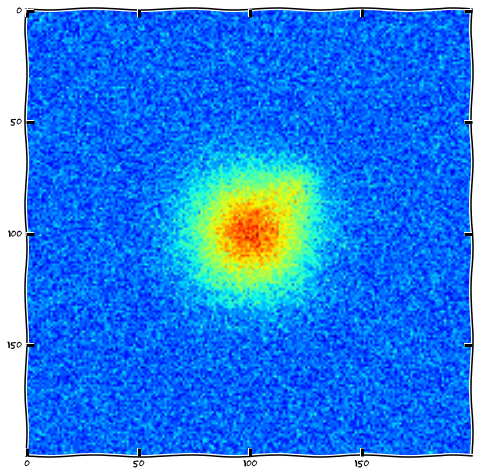

In [1]:
import numpy as np
import os

#gaussian function
def gaussian(x,y,cx,cy,A,R):
    return A*np.exp(-1./(R**2)*((x-cx)**2+(y-cy)**2))

#true properties of the data
IMAGE_SIZE = 200
CENTER = (IMAGE_SIZE/2., IMAGE_SIZE/2.)
CENTER2 = (CENTER[0]+IMAGE_SIZE/10., CENTER[1]-IMAGE_SIZE/10.)

#there are 2 Gaussians, a main central one and a radial one.
A1 = 10
R1 = 25
A2 = 3
#uncomment ot add another Gaussian in the mix.
R2 = 10

x = np.arange(IMAGE_SIZE)
xx,yy = np.meshgrid(x,x)

image = gaussian(xx,yy,CENTER[0], CENTER[1], A1, R1)
image += gaussian(xx,yy,CENTER2[0], CENTER2[1], A2, R2)

NOISE_LEVEL = 1 #scale of the noise.
noise = np.random.normal(size = image.shape)*NOISE_LEVEL

#uncomment out for noise
image+=noise

from matplotlib import pyplot as plt
plt.xkcd()
%matplotlib inline
from IPython.core.pylabtools import figsize
figsize(10,8)

plt.imshow(image)

###Multinest
Below if the multinest code.

Install insturctions are here: http://johannesbuchner.github.io/PyMultiNest/install.html 

It's important that you put

`$ export LD_LIBRARY_PATH=<path to libmultinest.so>:$LD_LIBRARY_PATH`

in you ~/.bashrc file after you make it. 

In [2]:
import pymultinest

N =1 #Use 1 gaussian. There's only one in the toy data but that can be changed
#this code will be written for an abritrary N

err = .1 #guess for the error. Not too important I've noticed.
inv_sigma2 = 1./(err**2)

def mn_prior(theta, ndim, nparams):
#prior distribution
#theta is of the form [c_x, c_y, A1, A2,...AN, R1,...RN]
    theta[0] = IMAGE_SIZE*theta[0]
    theta[1] = IMAGE_SIZE*theta[1]
    for n in xrange(N):
            theta[2+n] = 15*theta[2+n]
            theta[2+n+N] = 50*theta[2+n+N]
            #for astro images logUniform works better
            
def mn_loglike(theta, ndim, nparams):
#log liklihood of the passed theta parameter
    cx, cy = theta[:2]
    As = theta[2:2+N]
    Rs = theta[2+N:N*2+2]
    #model is a sum of given Gaussians
    model = sum(gaussian(xx,yy,cx,cy,A,R) for A,R in zip(As,Rs))
    #log of gaussian distance
    return -.5*(np.sum(((image-model)**2)*inv_sigma2-np.log(inv_sigma2)))

parameters = ['c_x', 'c_y']
parameters.extend(['A%d'%n for n in xrange(N)])
parameters.extend(['R%d'%n for n in xrange(N)])

n_params = len(parameters)

#multinest writes its results to files with this header
base_filename = 'sean_multinest'

In [3]:
#this will run for awhile. Output is printed to terminal, not here. 
#I suppose that's because it's C code. 
pymultinest.run(mn_loglike, mn_prior, n_params, outputfiles_basename = base_filename, resume = False, verbose = True)

In [4]:
analyzer = pymultinest.Analyzer(outputfiles_basename = base_filename, n_params = n_params)

post_samples = analyzer.get_equal_weighted_posterior()[:, :n_params]

#I am unsure wheter a mean or a mode is the best way to pick from the posterior
means = post_samples.mean(axis = 0)

calc_x, calc_y = means[:2]
calc_as = means[2:2+N]
calc_rs = means[2+N:2*N+2]

print 'True Center: (%f,%f)\tCalc Center: (%f,%f)'%(CENTER[0], CENTER[1], calc_x, calc_y)
print 'True A: %f\tTrue R: %f'%(A1, R1)
print 'Calc As: '+ str(calc_as)
print 'Calc Rs: ' + str(calc_rs)

calc_img = sum(gaussian(xx,yy,calc_x,calc_y,a,r) for a,r in zip(calc_as, calc_rs))

  analysing data from sean_multinest.txt
True Center: (100.000000,100.000000)	Calc Center: (101.067891,98.818683)
True A: 10.000000	True R: 25.000000
Calc As: [ 10.00718401]
Calc Rs: [ 25.71065288]


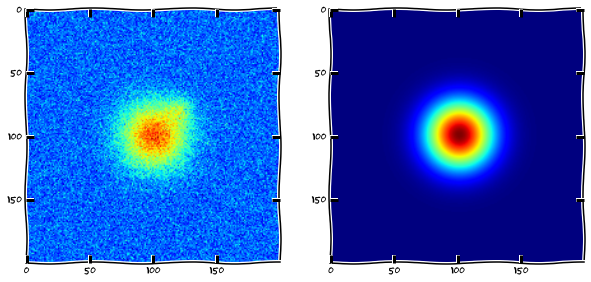

In [5]:
plt.subplot(121)
plt.imshow(image)
plt.subplot(122)
plt.imshow(calc_img)

The fit is on the right ,with the original on the left. 

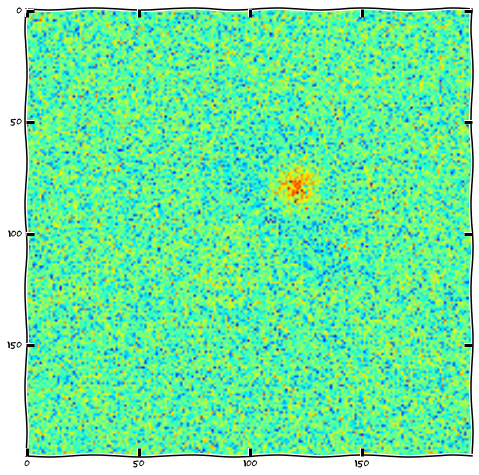

In [6]:
plt.imshow(image-calc_img)

In [17]:
Above, the difference. 